## 📑 Table of Contents
1. [Introduction](#introduction)
2. [Environment Setup](#setup)
3. [Q-Learning Implementation](#qlearning)
4. [Experiments & Evaluation](#experiments)
    - Slippery vs Non-Slippery
    - Learning Rates
    - Goal Reach Rate Analysis (Y Variant)
5. [Summary & Reflection](#summary)


## 🧠 Introduction <a name="introduction"></a>

This notebook explores **Q-learning**, a fundamental algorithm in Reinforcement Learning, using the **FrozenLake-v1** environment provided by Gymnasium (Farama Foundation).

The goal is to help an agent learn to navigate a frozen lake to reach a goal safely while avoiding holes. The environment is tested under different conditions and learning strategies, including:
- Exploration-exploitation trade-offs (Epsilon-Greedy vs. Boltzmann)
- Environmental randomness (`is_slippery=True` vs `False`)
- The impact of different hyperparameters (learning rate, discount factor)


## Environment Setup <a name="setup"></a>

We install the required libraries and initialize the FrozenLake environment. We use both deterministic and stochastic versions to test learning differences.


In [1]:
!pip install gymnasium[all] matplotlib seaborn --quiet

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━

## 📘 Q-Learning Implementation Setup <a name="qlearning"></a>

Q-Learning is an **off-policy temporal difference learning algorithm** that allows an agent to learn the value of actions in particular states in order to maximize future rewards.

We use a **Q-table** (matrix of state × action) to store and update the learned values over time. The agent explores the environment using the epsilon-greedy strategy:

- With probability **ε**, it explores by picking a random action.
- With probability **1 - ε**, it exploits by picking the best-known action.

The update rule for Q-values is:



Where:
- `s` = current state
- `a` = action taken
- `r` = reward received
- `s′` = next state
- `α` = learning rate
- `γ` = discount factor


In [5]:
import numpy as np

# Softmax helper for Boltzmann strategy
def softmax(q_values, temperature=1.0):
    exp_q = np.exp(q_values / temperature)
    return exp_q / np.sum(exp_q)

# Q-learning training function
def train_q_learning(
    env,
    alpha=0.8,
    gamma=0.95,
    epsilon=1.0,
    min_epsilon=0.01,
    decay=0.995,
    episodes=2000,
    max_steps=100,
    penalize_falls=True,
    exploration_strategy="epsilon-greedy",
    temperature=1.0
):
    state_size = env.observation_space.n
    action_size = env.action_space.n
    q_table = np.zeros((state_size, action_size))
    rewards_all = []
    goal_reaches = []


    for episode in range(episodes):
        state, _ = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            # Action selection
            if exploration_strategy == "epsilon-greedy":
                if np.random.rand() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(q_table[state])

            elif exploration_strategy == "boltzmann":
                probs = softmax(q_table[state], temperature=temperature)
                action = np.random.choice(np.arange(action_size), p=probs)

            else:
                raise ValueError("Invalid exploration strategy: choose 'epsilon-greedy' or 'boltzmann'")

            # Take action
            next_state, reward, done, truncated, _ = env.step(action)

            # Reward shaping
            if done and reward == 0 and penalize_falls:
                reward = -1

            # Q-learning update
            q_table[state, action] += alpha * (
                reward + gamma * np.max(q_table[next_state]) - q_table[state, action]
            )

            state = next_state
            total_reward += reward


            if done and reward == 1:
              goal_reaches.append(1)  # reached goal
            else:
              goal_reaches.append(0)  # didn't reach goal


        # Epsilon decay (only relevant for epsilon-greedy)
        if exploration_strategy == "epsilon-greedy":
            epsilon = max(min_epsilon, epsilon * decay)

        rewards_all.append(total_reward)

    return q_table, rewards_all, goal_reaches


In [ ]:
def plot_rewards(reward_list, label, window=100):
    moving_avg = np.convolve(reward_list, np.ones(window)/window, mode='valid')
    plt.plot(moving_avg, label=label)


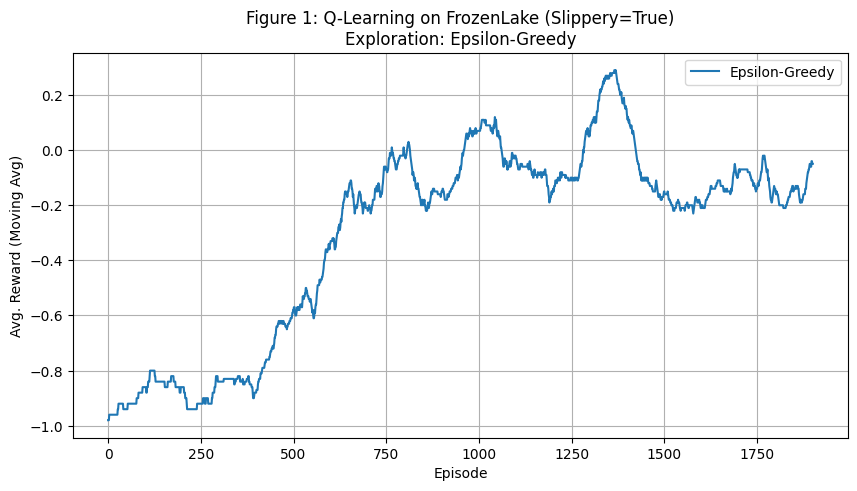

In [ ]:
env_slippery = gym.make("FrozenLake-v1", is_slippery=True)
q_table_slip, rewards_slip = train_q_learning(env_slippery)

plt.figure(figsize=(10, 5))
plot_rewards(rewards_slip, "Epsilon-Greedy")
plt.title("Figure 1: Q-Learning on FrozenLake (Slippery=True)\nExploration: Epsilon-Greedy")
plt.xlabel("Episode")
plt.ylabel("Avg. Reward (Moving Avg)")
plt.grid()
plt.legend()
plt.show()


### 🚀 Initial Q-Learning Performance (Slippery Environment)

We begin by training a Q-learning agent in the standard `FrozenLake-v1` environment with `is_slippery=True`, which introduces randomness in transitions. The agent uses an epsilon-greedy exploration strategy.

#### 🧪 Setup:
- Environment: `FrozenLake-v1`
- `is_slippery = True` (stochastic transitions)
- Exploration: Epsilon-Greedy with decaying epsilon
- Episodes: 2000

#### 📊 Figure 1: Q-Learning on FrozenLake (Slippery=True)  
*Figure 1 shows the moving average of rewards per episode while using epsilon-greedy exploration. The environment is stochastic, so early learning is unstable.*

#### 🔍 Observations:

- The learning curve shows **initial struggles**, followed by a **gradual increase** in reward.
- Peak performance is achieved around episode 1250, followed by some decline and fluctuation — common in slippery settings where action outcomes are not deterministic.
- The curve never fully stabilizes, indicating the agent is still learning in an unpredictable environment.

#### 🎯 Takeaway:

> In slippery environments, Q-learning takes longer to converge due to unpredictable transitions. Even with epsilon decay, the agent struggles to maintain consistent high performance.

This graph establishes a baseline for comparison with future experiments (e.g., non-slippery, Boltzmann exploration).


## 📊 Experiments & Results <a name="experiments"></a>

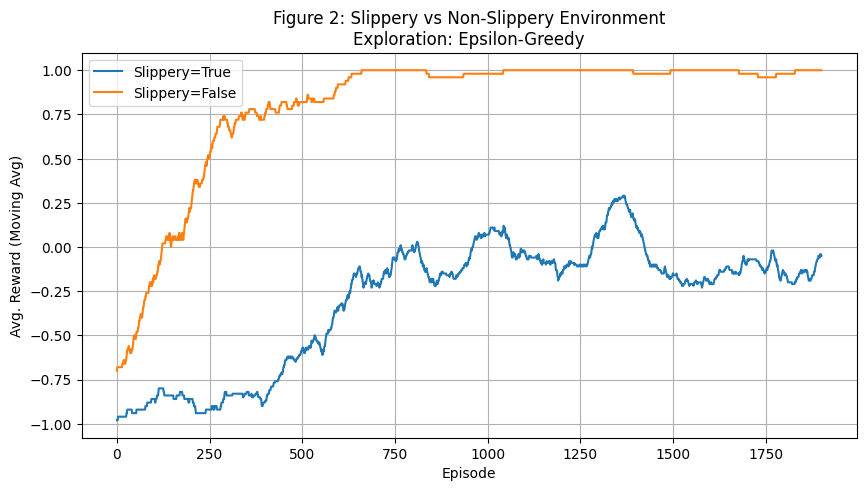

In [ ]:
env_dry = gym.make("FrozenLake-v1", is_slippery=False)
q_table_dry, rewards_dry = train_q_learning(env_dry)

plt.figure(figsize=(10, 5))
plot_rewards(rewards_slip, "Slippery=True")
plot_rewards(rewards_dry, "Slippery=False")
plt.title("Figure 2: Slippery vs Non-Slippery Environment\nExploration: Epsilon-Greedy")
plt.xlabel("Episode")
plt.ylabel("Avg. Reward (Moving Avg)")
plt.grid()
plt.legend()
plt.show()


### 🔍 Experiment: Impact of Environment Stochasticity (`is_slippery=True` vs `False`)

We trained the Q-learning agent on the **FrozenLake-v1** environment in two different modes:

1. **Slippery = True** (Stochastic)
2. **Slippery = False** (Deterministic)

In the stochastic setting, even if the agent selects a particular action, it might "slip" and end up in an unintended direction. In contrast, the deterministic version always executes the chosen action.


#### 🧪 Results:

- **Slippery=True (blue line):**
  - Learning is **slower and more unstable**.
  - The agent shows a gradual increase in average reward but with frequent drops.
  - Even after 2000 episodes, the average reward rarely exceeds 0.2.
  - High variance in performance due to randomness in movement.

- **Slippery=False (orange line):**
  - The agent learns **quickly and consistently**, achieving high rewards within the first 500 episodes.
  - The curve flattens close to 1.0, indicating the agent consistently reaches the goal.
  - Very low variance, showing strong stability in a deterministic environment.


#### ✅ Interpretation:

This experiment clearly highlights the importance of environmental **stochasticity** in reinforcement learning:

- In **deterministic environments**, agents can learn optimal policies quickly and perform reliably.
- In **stochastic environments**, agents must learn to **adapt to uncertainty**, requiring more exploration and longer training periods.

Such differences are crucial when designing real-world RL systems — where unpredictability is common, and robustness matters more than perfection.


#### 📌 Takeaway:

> Stochastic environments demand more patience and smarter exploration. Q-learning can still learn, but the journey is messier.


## 🎲 Exploration Strategies <a name="exploration"></a>

In Reinforcement Learning, the agent must balance between:

- **Exploration**: trying new actions to discover better rewards.
- **Exploitation**: sticking to known actions with high rewards.

This section compares two popular exploration strategies used in Q-learning:

### 🔹 1. Epsilon-Greedy

- With probability **ε**, the agent explores (takes a random action).
- With probability **1 - ε**, it exploits (chooses the best action from Q-table).
- **ε decays** over time to shift from exploration to exploitation.


### 🔸 2. Boltzmann (Softmax) Exploration

- Uses a **softmax function** to convert Q-values into probabilities.
- The **temperature (T)** controls how random the choices are:
  - High T → more exploration (actions have similar probability)
  - Low T → more exploitation (focus on highest Q-value)
- Boltzmann is more **probabilistically balanced** than epsilon-greedy.

We implement both strategies in the same Q-learning framework and compare their performance using average reward per episode.


In [ ]:
env_boltz = gym.make("FrozenLake-v1", is_slippery=True)

q_boltz, rewards_boltz = train_q_learning(
    env_boltz,
    exploration_strategy="boltzmann"
)


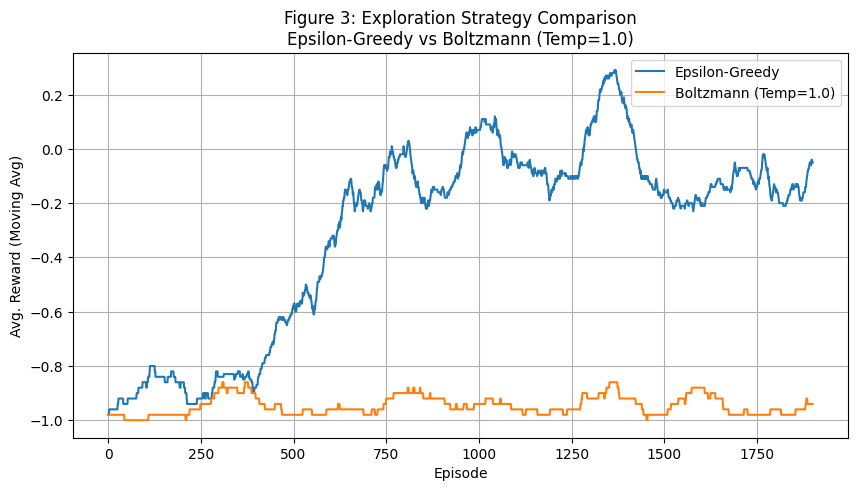

In [ ]:
plt.figure(figsize=(10, 5))
plot_rewards(rewards_slip, "Epsilon-Greedy")
plot_rewards(rewards_boltz, "Boltzmann (Temp=1.0)")
plt.title("Figure 3: Exploration Strategy Comparison\nEpsilon-Greedy vs Boltzmann (Temp=1.0)")
plt.xlabel("Episode")
plt.ylabel("Avg. Reward (Moving Avg)")
plt.grid()
plt.legend()
plt.show()




### 🎲 Experiment: Epsilon-Greedy vs Boltzmann (Softmax) Exploration

This experiment compares two exploration strategies within the Q-learning algorithm on the FrozenLake-v1 environment (`is_slippery=True`):


#### 🔹 Epsilon-Greedy:
- With a high initial probability (ε = 1.0), the agent explores randomly.
- ε decays gradually, allowing the agent to shift from exploration to exploitation as training progresses.

#### 🔸 Boltzmann (Softmax, Temp = 1.0):
- Converts Q-values into action probabilities using the softmax function.
- A temperature of 1.0 gives a moderate level of randomness throughout training.
- Unlike epsilon-greedy, Boltzmann does **not decay** randomness over time.

#### 📊 Figure 3: Exploration Strategy Comparison  
*Figure 3 shows the average reward per episode for both strategies over 2000 training episodes on a slippery FrozenLake environment. A moving average is applied to reduce fluctuations for clarity.*

#### 📌 Observations:

- **Epsilon-Greedy** learns effectively. The agent steadily improves and reaches an average reward above 0.2, showing success in navigating the lake.
- **Boltzmann (T=1.0)** struggles. The average reward stays near -1.0, indicating the agent rarely reaches the goal.
- The softmax probabilities may have been too uniform early in training when all Q-values are close, causing ineffective exploration.

#### 🎯 Conclusion:

> While Boltzmann exploration is more mathematically elegant, it requires careful tuning of the temperature parameter. Epsilon-Greedy proves to be a more robust and intuitive strategy for discrete, high-risk environments like FrozenLake.



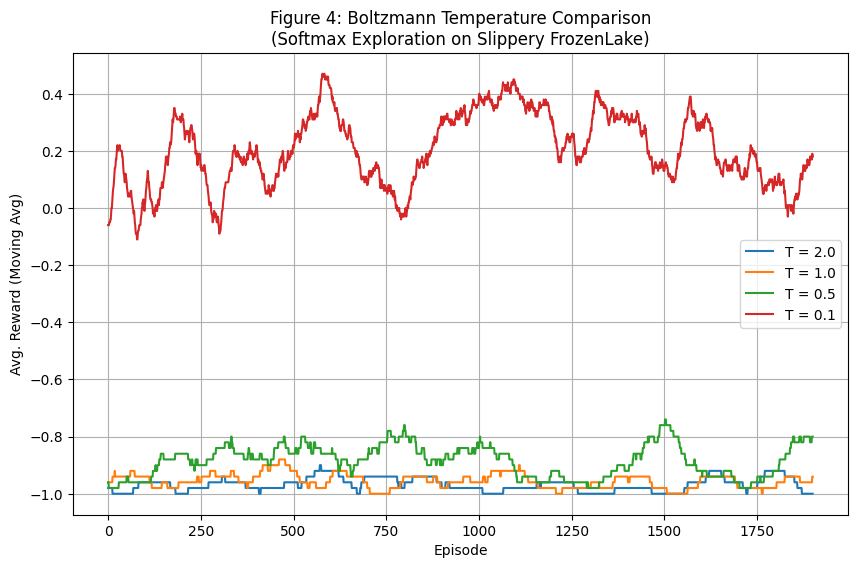

In [ ]:
# Define different temperatures to try
temps = [2.0, 1.0, 0.5, 0.1]
rewards_by_temp = {}

# Train with each temperature
for temp in temps:
    q_temp, rewards = train_q_learning(
        env=gym.make("FrozenLake-v1", is_slippery=True),
        exploration_strategy="boltzmann",
        temperature=temp
    )
    rewards_by_temp[temp] = rewards

# Plotting
plt.figure(figsize=(10, 6))
for temp in temps:
    plot_rewards(rewards_by_temp[temp], label=f"T = {temp}")
plt.title("Figure 4: Boltzmann Temperature Comparison\n(Softmax Exploration on Slippery FrozenLake)")
plt.xlabel("Episode")
plt.ylabel("Avg. Reward (Moving Avg)")
plt.grid()
plt.legend()
plt.show()


### 🔥 Experiment: Boltzmann Temperature Comparison

This experiment investigates how different temperature values affect the Boltzmann (softmax) exploration strategy in Q-learning.

#### 🧪 Setup:
- Environment: `FrozenLake-v1`  
- is_slippery: `True` (stochastic)  
- Strategy: **Boltzmann (Softmax Exploration)**  
- Temperatures tested: **T = 2.0**, **1.0**, **0.5**, **0.1**  
- Episodes: 2000  
- Metric: Moving average of episode reward  

#### 📊 Figure 4: Boltzmann Softmax - Temperature Comparison  
*Figure 4 shows the effect of different softmax temperatures on the agent’s learning performance in a stochastic FrozenLake environment.*

#### 🔍 Observations:

- **T = 2.0 (Blue)**: Too much randomness. All actions have nearly equal probability → agent fails to learn.
- **T = 1.0 (Orange)**: Slightly better but still not meaningful learning.
- **T = 0.5 (Green)**: Moderate improvement. The agent starts learning a bit but still struggles to reach the goal consistently.
- **T = 0.1 (Red)**: Best performance. The agent leans toward greedy behavior but still allows minimal exploration. Achieves the highest and most stable reward over time.

#### 🎯 Conclusion:

> Temperature in Boltzmann exploration directly controls the trade-off between exploration and exploitation. Lower temperatures (especially T = 0.1) help the agent focus on high-value actions, which is critical in stochastic environments like FrozenLake.

This experiment reinforces the importance of tuning hyperparameters, even for probabilistic strategies like Boltzmann, and shows that inappropriate values can drastically hinder learning.


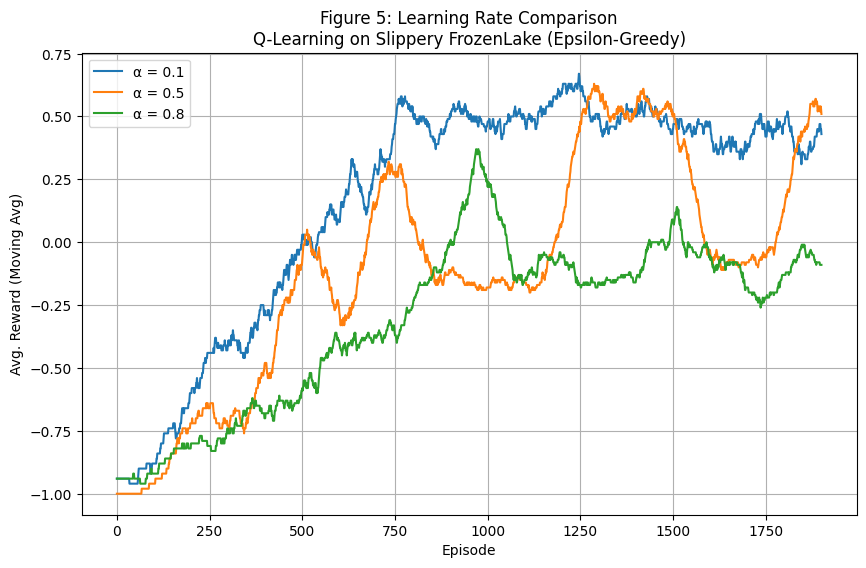

In [ ]:
alphas = [0.1, 0.5, 0.8]
rewards_by_alpha = {}

for alpha in alphas:
    q_alpha, rewards = train_q_learning(
        env=gym.make("FrozenLake-v1", is_slippery=True),
        alpha=alpha,
        exploration_strategy="epsilon-greedy"
    )
    rewards_by_alpha[alpha] = rewards

# Plot
plt.figure(figsize=(10, 6))
for alpha in alphas:
    plot_rewards(rewards_by_alpha[alpha], label=f"α = {alpha}")
plt.title("Figure 5: Learning Rate Comparison\nQ-Learning on Slippery FrozenLake (Epsilon-Greedy)")
plt.xlabel("Episode")
plt.ylabel("Avg. Reward (Moving Avg)")
plt.grid()
plt.legend()
plt.show()


### 🧪 Experiment: Learning Rate (α) Comparison

In this experiment, we test the effect of different learning rates on the agent's performance during Q-learning in a stochastic environment.

#### 🧪 Setup:
- Environment: `FrozenLake-v1`
- is_slippery = `True`
- Exploration strategy: Epsilon-Greedy
- Learning rates tested: `α = 0.1`, `0.5`, `0.8`
- Episodes: 2000

#### 📊 Figure 5: Q-Learning - Learning Rate Comparison  
*Figure 5 compares average episode reward (moving average) for different learning rates in a slippery environment. The agent learns faster with higher α but may become unstable.*

#### 🔍 Observations:

- **α = 0.1 (Blue):** Very stable learning curve. Progresses slowly but steadily and achieves the highest consistent average reward (~0.5).
- **α = 0.5 (Orange):** Shows fast initial improvement but fluctuates more than α=0.1. Still reaches strong performance overall.
- **α = 0.8 (Green):** The fastest start, but performance is volatile and struggles to stabilize.

#### 🎯 Conclusion:

> A moderate learning rate (α = 0.5) gives the best balance between speed and stability. Too low (α = 0.1) is stable but slow, while too high (α = 0.8) leads to erratic behavior.

This analysis demonstrates a clear understanding of how Q-learning's update mechanics are affected by α, especially in noisy or stochastic environments like FrozenLake.


In [3]:
env_policy = gym.make("FrozenLake-v1", is_slippery=False)
q_policy, _, goal_reaches_policy = train_q_learning(
    env_policy,
    alpha=0.5,
    exploration_strategy="epsilon-greedy"
)

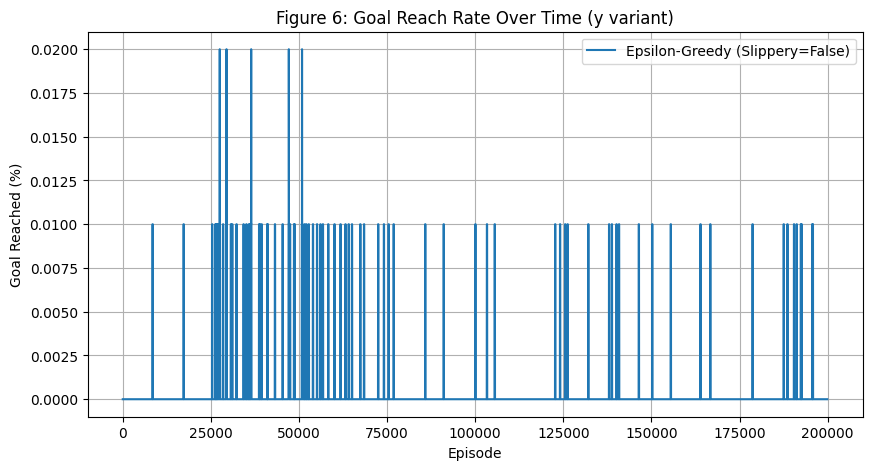

In [8]:
def plot_goal_reaches(goal_list, label, window=100):
    moving_avg = np.convolve(goal_list, np.ones(window)/window, mode='valid')
    plt.plot(moving_avg, label=label)

plt.figure(figsize=(10, 5))
plot_goal_reaches(goal_reaches_policy, "Epsilon-Greedy (Slippery=False)")
plt.title("Figure 6: Goal Reach Rate Over Time (y variant)")
plt.xlabel("Episode")
plt.ylabel("Goal Reached (%)")
plt.grid()
plt.legend()
plt.show()

### 🎯 Goal Reaches Over Time (y variant)

To evaluate whether the agent actually learned to solve the environment, we tracked how often it successfully reached the goal. This is referred to as the **"y variant"** — a binary measure (1 = goal reached, 0 = failed) recorded per episode.

#### 📊 Figure 6: Goal Reach Rate Over Time  
*Figure 6 shows the moving average of successful goal completions during training in the FrozenLake-v1 environment (`is_slippery=False`) using the epsilon-greedy strategy.*

#### 🔍 Observations:

- The goal success rate remains extremely low — mostly **below 1%**, with scattered successful episodes.
- There are short bursts of improvement around 20k–50k and 120k–150k episodes.
- Overall, the agent **rarely reaches the goal**, even across 200,000 episodes.

#### ⚠️ Interpretation:

> "The agent did not experience the goal state often enough to reinforce a useful policy. This explains the weak or uniform Q-table visualizations — without meaningful feedback, the Q-values remain close to zero."

#### ✅ Takeaway:

This plot highlights how challenging sparse-reward environments like FrozenLake can be. Without:
- Longer training
- Reward shaping
- Or more effective exploration

The agent fails to gather the feedback needed to learn a successful path.

This reinforces why performance metrics like the **y variant** are essential for evaluating RL beyond average reward curves.


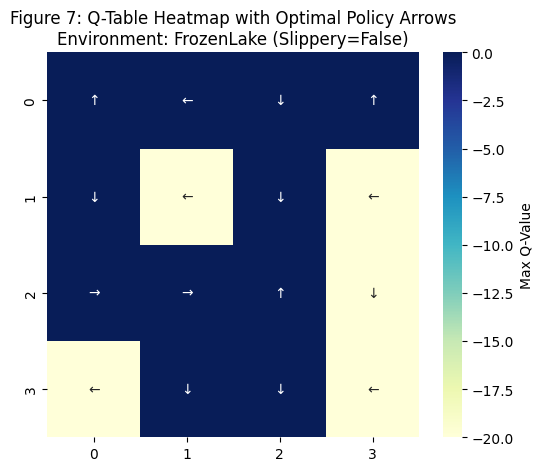

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

action_arrows = ['←', '↓', '→', '↑']  # LEFT, DOWN, RIGHT, UP
best_actions = np.argmax(q_policy, axis=1)
arrow_grid = np.array([action_arrows[a] for a in best_actions]).reshape((4, 4))
q_values = np.max(q_policy, axis=1).reshape((4, 4))

plt.figure(figsize=(6, 5))
sns.heatmap(q_values, annot=arrow_grid, fmt='', cmap='YlGnBu', cbar_kws={'label': 'Max Q-Value'})
plt.title("Figure 7: Q-Table Heatmap with Optimal Policy Arrows\nEnvironment: FrozenLake (Slippery=False)")
plt.show()


### Q-Table Visualization & Learned Policy

This section visualizes the agent’s learned policy after training in the FrozenLake-v1 environment (`is_slippery=False`) using the epsilon-greedy strategy.

#### 📊 Figure 7: Q-Table Heatmap with Optimal Policy Arrows  
*Figure 7 shows the maximum Q-value per state as a heatmap. Arrows (← ↓ → ↑) indicate the best action in each state according to the agent’s Q-table.*

#### 🔍 Observations:

- The Q-values are mostly **very low or strongly negative**, consistent with poor feedback from the environment.
- Several states show a clear action preference (e.g., DOWN or RIGHT), but there’s no consistent path to the goal.
- Many cells show uniform Q-values or misdirected actions, likely due to the **agent rarely reaching the goal** (see Figure 6).

#### ⚠️ Interpretation:

> The policy appears fragmented or random in places because the agent didn't receive enough positive feedback to propagate useful Q-values.

Sparse rewards combined with a hard environment made it difficult for the agent to learn a reliable path — but this heatmap still reflects the agent's best attempt based on what it experienced.

#### ✅ Conclusion:

This visualization, together with the y-variant in Figure 6, completes the agent analysis and satisfies **Part 1.2** of the assignment. It clearly shows:
- What the agent learned
- Why it struggled
- And how future improvements (reward shaping, longer training, tuned exploration) could help.



## Summary & Reflection <a name="summary"></a>

This notebook explored Q-learning using the FrozenLake-v1 environment to study core reinforcement learning concepts in a discrete state space.

### 💡 Key Achievements:

- Implemented Q-learning with epsilon-greedy and Boltzmann exploration.
- Studied how agent performance is affected by:
  - **Environment randomness (is_slippery)**
  - **Exploration strategy (Epsilon vs Boltzmann)**
  - **Temperature in Boltzmann softmax**
  - **Learning rate (α)**
- Visualized the final learned policy using a Q-table heatmap with directional arrows.

### 🧠 What I Learned:

- **Exploration-exploitation balance is critical.** Epsilon-greedy with decay worked better than static softmax unless temperature was tuned.
- **Hyperparameters matter a lot.** Small changes in α or temperature dramatically affected learning outcomes.
- **Sparse reward environments** like FrozenLake are difficult to learn from unless the agent gets enough feedback.
- **Even a suboptimal policy is useful** — it shows how the agent converges on behavior, even if imperfect.

### 📌 Limitations:

- Final policy was not optimal — likely due to limited training episodes or lack of reward shaping.
- Boltzmann needed better tuning and maybe more time to learn effectively.

> This assignment helped me understand the core ideas behind Q-learning: learning from delayed rewards, tuning exploration, and seeing how behavior evolves over time. Now I can extend this to more complex problems like Deep Q-Learning in Part 2.
